<h1> Rascunho trabalho sobre ENEM </h1>

Nesta aplicação utilizaremos os dados do [ENEM 2016](https://www.kaggle.com/gbonesso/enem-2016/version/2) para prever alguns aspectos. <br>

<h1> Pré-processamento </h1>

In [1]:
import pandas as pd

In [2]:
column_names = ['CO_UF_ESC', 'TP_ESCOLA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

In [3]:
test = pd.read_csv("microdados_enem_2016_coma.csv", usecols = column_names)

<b> Aqui verificamos que temos várias linhas com valores nulos. Como o _data set_ é bem grande, optou-se por remover essas linhas. </b>

In [35]:
test.isnull().sum()

TP_ESCOLA                0
CO_UF_ESC          6746085
NU_NOTA_CN         2628425
NU_NOTA_CH         2628241
NU_NOTA_LC         2782212
NU_NOTA_MT         2782396
NU_NOTA_REDACAO    2782396
dtype: int64

In [36]:
test_limpo = test.dropna()
test_limpo.reset_index(drop=True, inplace=True)

<b> Abaixo podemos ver os tipos de dados que teremos que lidar. A princípio nenhuma conversão necessita ser feita. </b>

In [37]:
test_limpo.dtypes

TP_ESCOLA            int64
CO_UF_ESC          float64
NU_NOTA_CN         float64
NU_NOTA_CH         float64
NU_NOTA_LC         float64
NU_NOTA_MT         float64
NU_NOTA_REDACAO    float64
dtype: object

In [38]:
test_limpo.tail()

,TP_ESCOLA,CO_UF_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
1519246,2,35.0,477.9,527.7,543.7,430.7,280.0
1519247,2,35.0,374.1,514.0,530.8,451.8,360.0
1519248,2,42.0,544.5,488.2,530.7,413.0,520.0
1519249,2,50.0,438.3,509.6,537.9,541.7,520.0
1519250,2,35.0,495.6,545.2,529.3,397.4,740.0


<h1> Definindo conjuntos de treino e teste </h1>

In [89]:
import __future__ #for future features in newer versions
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
train_dataset = test_limpo.sample(frac=0.75,random_state=0) #the random_state gives the seed for the randomization 
test_dataset = test_limpo.drop(train_dataset.index)

<b> A _label_ é o que queremos prever (nesse caso, a nota da redação): </b>

In [42]:
train_labels = train_dataset.pop('NU_NOTA_REDACAO')
test_labels = test_dataset.pop('NU_NOTA_REDACAO')

<b> É importante também observar como está a distribuição dos dados, já que nesse caso estamos trabalhando com valores numéricos: </b>

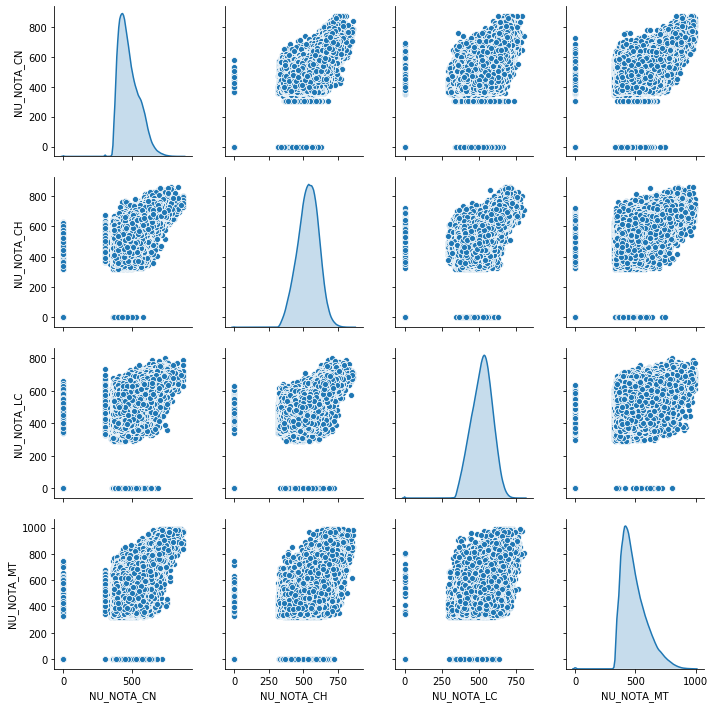

In [53]:
sns.pairplot(train_dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']], diag_kind="kde")

In [54]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
TP_ESCOLA,1139438.0,2.197201,0.397885,2.0,2.0,2.0,2.0,3.0
CO_UF_ESC,1139438.0,32.001914,9.795791,11.0,26.0,33.0,35.0,53.0
NU_NOTA_CN,1139438.0,479.797963,74.386321,0.0,422.2,464.5,527.5,871.3
NU_NOTA_CH,1139438.0,533.940032,74.623512,0.0,483.7,536.7,586.4,859.1
NU_NOTA_LC,1139438.0,520.175176,69.320915,0.0,472.4,523.8,568.9,802.6
NU_NOTA_MT,1139438.0,490.290840,105.326461,0.0,411.7,466.7,548.7,991.5


<b> Como podemos notar, os dados estão em intervalos distintos. Uma boa prática consiste em normalizar os dados, apesar de isso não ser obrigatório. </b>

In [90]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

<h1> Rede Neural Artificial </h1>

Para construir o modelo, utilizamos as _rules-of-thumb_ [deste](https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930a) artigo. 

In [91]:
#6 features/colunas + 1 (redacao)
def build_model():
    model = keras.Sequential([
        layers.Input(len(train_dataset.keys())), #input_shape = 6
        layers.Dense(4, activation = 'relu'),
        layers.Dense(2, activation = 'relu'),
        layers.Dense(1, activation = 'linear'), #1 nota possível
    ])

    model.compile(loss = 'mse', optimizer = 'adam', metrics =['mean_absolute_error', 'mean_squared_error']) 

    return model

In [92]:
model = build_model()
print(model.summary())

#params = atual *(anterior +1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 3         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None


<b> Vejamos se o treinamento mostra diminuição do _loss_ e ...: </b>

In [64]:
predicted_labels_ANN = model.fit(train_dataset, train_labels, epochs=20)

Epoch 1/20
1139438/1139438 [==============================] - 54s 47us/sample - loss: 14992.6019 - mean_absolute_error: 88.9447 - mean_squared_error: 14992.5088
Epoch 2/20
1139438/1139438 [==============================] - 72s 63us/sample - loss: 14856.7179 - mean_absolute_error: 88.6386 - mean_squared_error: 14856.8145
Epoch 3/20
1139438/1139438 [==============================] - 49s 43us/sample - loss: 14764.3257 - mean_absolute_error: 88.5575 - mean_squared_error: 14764.2979
Epoch 4/20
1139438/1139438 [==============================] - 53s 47us/sample - loss: 14715.6718 - mean_absolute_error: 88.5582 - mean_squared_error: 14715.6621
Epoch 5/20
1139438/1139438 [==============================] - 54s 48us/sample - loss: 14702.9405 - mean_absolute_error: 88.5992 - mean_squared_error: 14702.9746
Epoch 6/20
1139438/1139438 [==============================] - 56s 49us/sample - loss: 14690.6978 - mean_absolute_error: 88.6140 - mean_squared_error: 14690.6748
Epoch 7/20
1139438/1139438 [======

In [93]:
hist = pd.DataFrame(predicted_labels_ANN.history)
hist['epoch'] = predicted_labels_ANN.epoch
hist

,loss,mean_absolute_error,mean_squared_error,epoch
0,14992.601945,88.944687,14992.508789,0
1,14856.717915,88.638649,14856.814453,1
2,14764.325733,88.557533,14764.297852,2
3,14715.671790,88.558189,14715.662109,3
4,14702.940486,88.599197,14702.974609,4
5,14690.697801,88.614006,14690.674805,5
6,14686.224111,88.633301,14686.209961,6
7,14678.472151,88.637047,14678.417969,7
8,14679.126643,88.639366,14679.138672,8
9,14676.772111,88.643837,14676.788086,9


<h1> Naive Bayes </h1>

Apenas um primeiro chute:

In [81]:
from sklearn.naive_bayes import BernoulliNB

modelB = BernoulliNB().fit(normed_train_data, train_labels) 

In [82]:
predicted_label = modelB.predict(normed_test_data)

In [87]:
#https://scikit-learn.org/stable/modules/classes.html#regression-metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

score1 = mean_absolute_error(test_labels, predicted_label) 
score2 = mean_squared_error(test_labels, predicted_label)
print (score1)
print(score2)

95.95315326226327
17134.902236100395
